# Dual-Network Hydrogel Mastercurve

Auto TTS on dual-network hydrogels across temperature.

**Data:** examples/data/temperature_sweep/hydrogels/*.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import FractionalMaxwellModel, GeneralizedMaxwell, HerschelBulkley
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import os
import sys

import arviz as az

# Shared plotting utilities
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")), ".."))
from utils.plotting_utils import display_arviz_diagnostics


## Load multi-temperature sweeps (UTF-16)

In [3]:
# Find data directory - handle different CWD scenarios (IDE vs nbconvert)
import codecs
from io import StringIO

# Try multiple candidate paths for robustness
_data_path_candidates = [
    Path.cwd().parent / 'data' / 'temperature_sweep' / 'hydrogels',  # CWD = notebook dir
    Path.cwd() / 'examples' / 'verification' / 'data' / 'temperature_sweep' / 'hydrogels',  # CWD = project root
    Path.cwd() / 'examples' / 'data' / 'temperature_sweep' / 'hydrogels',  # CWD = project root (alt)
]

DATA_DIR = None
for _candidate in _data_path_candidates:
    if _candidate.exists() and len(list(_candidate.glob('*.csv'))) > 0:
        DATA_DIR = _candidate
        break

if DATA_DIR is None:
    raise FileNotFoundError(
        f"No CSV files found in any candidate path. CWD={Path.cwd()}\n"
        f"Tried: {[str(c) for c in _data_path_candidates]}"
    )

files = sorted(DATA_DIR.glob('*.csv'))
print(f"Found {len(files)} CSV files in {DATA_DIR}")

datasets = []
for fpath in files:
    stem = fpath.stem
    temp_token = stem.split('_')[-1]
    temp_c = float(temp_token.replace('c','').replace('h',''))
    
    # Read UTF-16 files using codecs (pandas has issues with UTF-16-LE)
    try:
        with codecs.open(fpath, 'r', encoding='utf-16') as f:
            content = f.read()
        # Skip header rows (0-10) + units row, data starts at row 12
        # Files have alternating blank lines so we filter them out
        df = pd.read_csv(StringIO(content), sep='\t', skiprows=11, 
                        names=['omega', 'Gp', 'Gpp'], decimal=',', skip_blank_lines=True)
    except Exception as e:
        print(f"Warning: Could not read {fpath.name}: {e}")
        continue
        
    df = df.dropna()
    df['omega'] = pd.to_numeric(df['omega'], errors='coerce')
    df['Gp'] = pd.to_numeric(df['Gp'], errors='coerce')
    df['Gpp'] = pd.to_numeric(df['Gpp'], errors='coerce')
    df = df.dropna()
    if df.empty:
        continue
    omega = df['omega'].to_numpy()
    Gp = df['Gp'].to_numpy()
    Gpp = df['Gpp'].to_numpy()
    datasets.append(RheoData(x=omega, y=Gp + 1j*Gpp, x_units='rad/s', y_units='Pa', domain='oscillation', metadata={'temperature': temp_c + 273.15, 'test_mode': 'oscillation'}))

if not datasets:
    raise ValueError("No valid datasets loaded from CSV files")
    
print(f"Loaded {len(datasets)} datasets")

mc = Mastercurve(reference_temp=298.15, method='wlf', auto_shift=True)
try:
    master, shifts = mc.create_mastercurve(datasets, return_shifts=True)
except Exception as exc:
    print(f"Auto-shift failed: {exc}; falling back to manual identity shifts")
    manual_shifts = {d.metadata['temperature']: 1.0 for d in datasets}
    mc = Mastercurve(reference_temp=298.15, method='manual', auto_shift=False)
    mc.set_manual_shifts(manual_shifts)
    master, shifts = mc.create_mastercurve(datasets, return_shifts=True)

print(f"Temps (C): {[round(d.metadata['temperature']-273.15,1) for d in datasets]}")
print(shifts)

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


Found 15 CSV files in /Users/b80985/Projects/rheojax/examples/verification/data/temperature_sweep/hydrogels
Loaded 6 datasets


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.655446s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=0.0160 | elapsed=3.655s | final_gradient_norm=0.0016


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.885417s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=0.0050 | elapsed=0.885s | final_gradient_norm=2.2855e-04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.883682s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=0.0018 | elapsed=0.884s | final_gradient_norm=0.0184


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.722001s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=9.7304e-04 | elapsed=0.722s | final_gradient_norm=0.0037


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.355408s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=0.0010 | elapsed=0.355s | final_gradient_norm=0.0089


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.565446s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=5.2474e-04 | elapsed=0.565s | final_gradient_norm=0.0057


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.546210s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=4.2723e-04 | elapsed=0.546s | final_gradient_norm=2.5688e-05


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.586873s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=2.0817e-04 | elapsed=0.587s | final_gradient_norm=0.0024


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.676278s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=0.0010 | elapsed=0.676s | final_gradient_norm=0.0011


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.642215s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=7.6872e-04 | elapsed=0.642s | final_gradient_norm=0.0127


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.651086s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=38 | final_cost=0.0126 | elapsed=0.651s | final_gradient_norm=2.4184e+05


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.623282s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=33 | final_cost=0.0088 | elapsed=0.623s | final_gradient_norm=1.2757e+04


Temps (C): [10.0, 10.0, 20.0, 30.0, 40.0, 50.0]
{283.15: np.float64(1.1147813481221043), 293.15: np.float64(1.0), 303.15: np.float64(2.0716235222245243), 313.15: np.float64(4013.571488572925), 323.15: np.float64(0.00029861617478479154)}


## Plot raw vs shifted

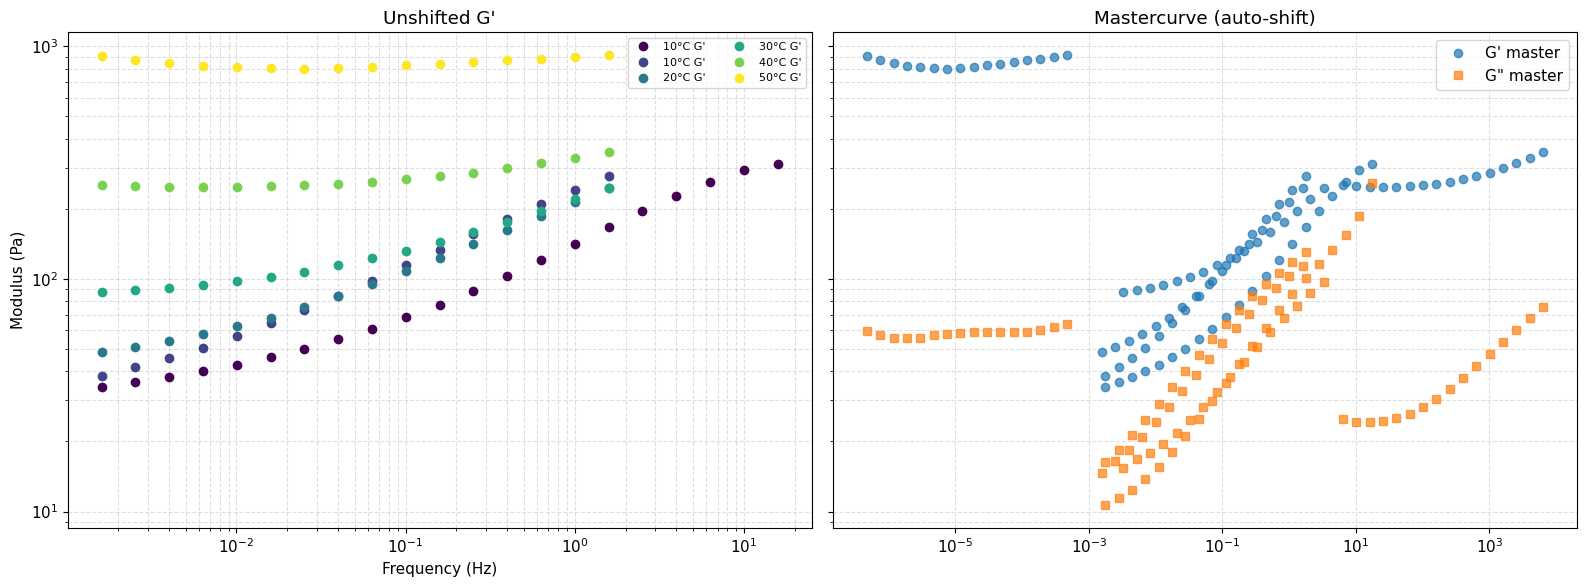

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(datasets)))
for c, data in zip(colors, datasets):
    temp_c = data.metadata['temperature'] - 273.15
    axes[0].loglog(data.x/(2*np.pi), np.real(data.y), 'o', color=c, label=f"{temp_c:.0f}°C G'")
axes[0].set_title("Unshifted G'")
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Modulus (Pa)')
axes[0].grid(True, which='both', ls='--', alpha=0.4)
axes[0].legend(ncol=2, fontsize=8)

axes[1].loglog(master.x/(2*np.pi), np.real(master.y), 'o', label="G' master", alpha=0.7)
axes[1].loglog(master.x/(2*np.pi), np.imag(master.y), 's', label='G" master', alpha=0.7)
axes[1].set_title('Mastercurve (auto-shift)')
axes[1].grid(True, which='both', ls='--', alpha=0.4)
axes[1].legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Fit models on mastercurve

In [5]:
omega_master = master.x
G_master = master.y

gm = GeneralizedMaxwell(n_modes=5, modulus_type='tensile')
gm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega_master)
gm_pred = gm_pred_components[:,0] + 1j*gm_pred_components[:,1]
gm_r2 = r2_complex(G_master, gm_pred)

fm_pred = np.full_like(G_master, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega_master, test_mode='oscillation')
    fm_r2 = r2_complex(G_master, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.233238s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=3.8478e+06 | elapsed=3.233s | final_gradient_norm=3.4857e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.654455s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=3.8478e+06 | elapsed=0.654s | final_gradient_norm=3.4857e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.239413s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=1 | final_cost=3.8475e+06 | elapsed=2.239s | final_gradient_norm=2.8903e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.565545s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=5 | final_cost=3.8448e+06 | elapsed=2.566s | final_gradient_norm=6.6351e+05


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.813293s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=3 | final_cost=3.8475e+06 | elapsed=2.813s | final_gradient_norm=4.2692e+06


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.962951s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=5 | final_cost=3.8442e+06 | elapsed=0.963s | final_gradient_norm=180.6582


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.782482s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=33 | final_cost=24.6776 | elapsed=2.782s | final_gradient_norm=421.9550


{'gm_r2': -0.03187858969481505, 'fm_r2': -0.556367321715443}


## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [6]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [7]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 2 dataset(s) and 2 model(s)


In [8]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.806169s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=2.0546e+04 | elapsed=0.806s | final_gradient_norm=2.5186e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.790505s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=69 | final_cost=0.0634 | elapsed=1.791s | final_gradient_norm=1.7072e-04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Dataset 0 ranking: [('gm', -0.748), ('fm', -2.82)]


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.563325s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=3.8442e+06 | elapsed=0.563s | final_gradient_norm=5.6649e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.031856s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=33 | final_cost=24.6776 | elapsed=1.032s | final_gradient_norm=421.9550


Dataset 1 ranking: [('gm', -0.032), ('fm', -0.556)]


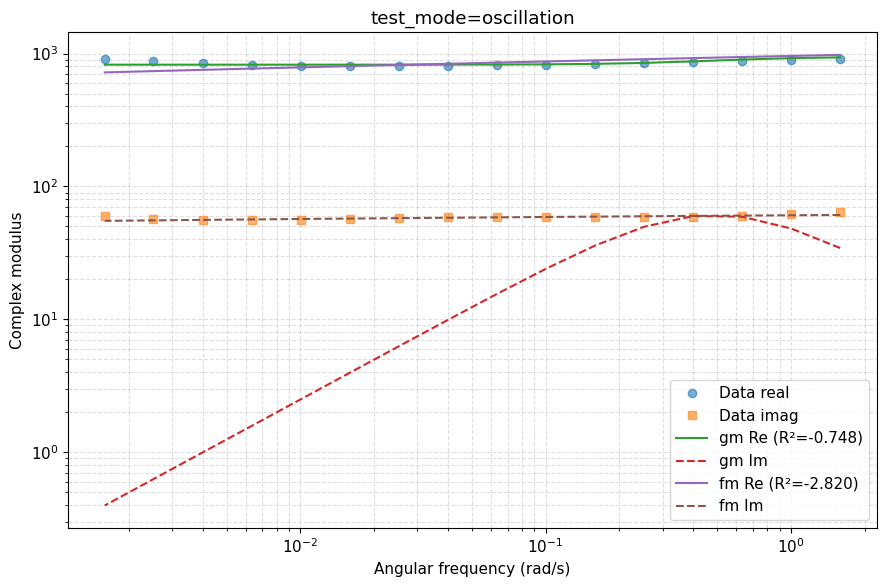

ERROR:rheojax.core.bayesian:bayesian_inference failed: Incompatible shapes for broadcasting: shapes=[(16, 2), (16,)]


ERROR:rheojax.core.base:Bayesian fit failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/jax/_src/lax/lax.py", line 215, in _broadcast_shapes_uncached
    return _try_broadcast_shapes(*rank_promoted_shapes, name='broadcast_shapes')
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/jax/_src/lax/lax.py", line 130, in _try_broadcast_shapes
    raise TypeError(f'{name} got incompatible shapes for broadcasting: '
                    f'{", ".join(map(str, map(tuple, shapes)))}.')
TypeError: broadcast_shapes got incompatible shapes for broadcasting: (16, 2), (1, 16).

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/jax/_src/lax/lax.py", line 193, in broadcast_shapes
    return _broadcast_shapes_cached(*shapes)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-pac

Dataset 0: Bayesian step failed for gm: Incompatible shapes for broadcasting: shapes=[(16, 2), (16,)]


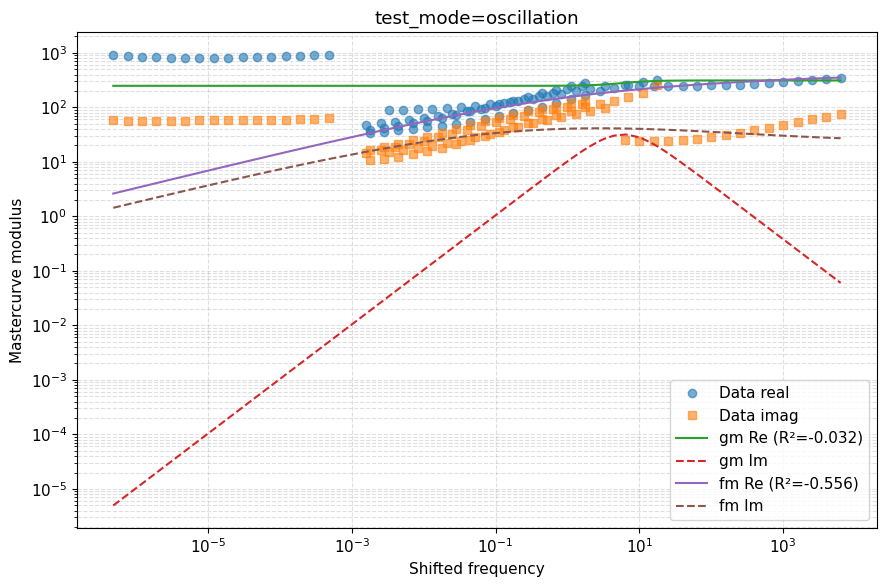

ERROR:rheojax.core.bayesian:bayesian_inference failed: Incompatible shapes for broadcasting: shapes=[(101, 2), (101,)]


ERROR:rheojax.core.base:Bayesian fit failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/jax/_src/lax/lax.py", line 215, in _broadcast_shapes_uncached
    return _try_broadcast_shapes(*rank_promoted_shapes, name='broadcast_shapes')
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/jax/_src/lax/lax.py", line 130, in _try_broadcast_shapes
    raise TypeError(f'{name} got incompatible shapes for broadcasting: '
                    f'{", ".join(map(str, map(tuple, shapes)))}.')
TypeError: broadcast_shapes got incompatible shapes for broadcasting: (101, 2), (1, 101).

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/jax/_src/lax/lax.py", line 193, in broadcast_shapes
    return _broadcast_shapes_cached(*shapes)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-p

Dataset 1: Bayesian step failed for gm: Incompatible shapes for broadcasting: shapes=[(101, 2), (101,)]


In [9]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: (bayes_result, param_names)}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        param_names = list(best['model'].parameters.keys())
        bayes_results[ds_idx] = (bayes_result, param_names)
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")


In [10]:
# ArviZ diagnostics for Bayesian results
for ds_idx, (bayes_result, param_names) in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    display_arviz_diagnostics(bayes_result, param_names, fast_mode=True)
